# 4_Evaluation_RAG+FT.ipynb
## Notebook Overview: Evaluation of RAG + Finetuned Model

This notebook evaluates the performance of our final RAG+FT pipeline across all question types:
- Runs inference using retrieved context + finetuned DeepSeek model
- Applies question-type-specific answer extraction
- Computes accuracy or qualitative evaluation


---
- **Version 1: using pinecone INDEX 1: "rag-trainset-index" with 411 k entries**: Advanced RAG on 400k training data & 11 k PubMed data in Pinecone
---
- **Version 2: using pinecone INDEX 2: "balanced-index" with 200 k entries**: (**extension after final presentation**): Advanced RAG on 100 k training data (True-False questions only included that contain true answers) with balanced 20 k per question type & 100 k PubMed abstracts in Pinecone

# Version 1: 400 k training data, 11 k PubMed data samples (imbalanced)
- training data contained all True-False questions

In [ ]:
! pip install langchain_pinecone
!pip install pinecone sentence-transformers
! pip install langchain_community
! pip install rouge_score
! pip install bert_score
! pip install datasets
#! python -m spacy download en_core_web_md

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.11.15
    Uninstalling aiohttp-3.11.15:
      Successfully uninstalled aiohttp-3.11.15
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:

import pprint
import json
import logging
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
import torch
from utils.RAG_preprocessing import DataPaths
from datasets import Dataset, DatasetDict

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/LorenaRaichle/ClinIQ.git
%cd /content/ClinIQ
from google.colab import userdata
from pinecone import Pinecone, ServerlessSpec
PINECONE = userdata.get('PINECONE')
pc = Pinecone(PINECONE)

from utils.RAG_pinecone import init_index, RAGIndexer

Cloning into 'ClinIQ'...
remote: Enumerating objects: 36251, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 36251 (delta 20), reused 26 (delta 10), pack-reused 36189 (from 1)
Receiving objects: 100% (36251/36251), 176.29 MiB | 32.70 MiB/s, done.
Resolving deltas: 100% (12982/12982), done.
Updating files: 100% (142/142), done.


In [ ]:
index = init_index(pc)
indexer = RAGIndexer(index)


Index rag-trainset-index already exists.


In [ ]:
indexer.describe_index()

{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 411857}},
 'total_vector_count': 411857,
 'vector_type': 'dense'}

### Loading datasets

In [ ]:
# Load full training data (to look up for retrieved id the context)
train_data = DataPaths.load("train_processed")
full_data = DatasetDict({
    split: Dataset.from_list(data) for split, data in train_data.items()
})

# Load PubMed context data (to look up for retrieved id the context)
pubmed_data = DataPaths.load("pubmed_preprocessed_250k")

# Load test data
with open(DataPaths.paths["test_processed"], "r") as f:
    test_data_raw = json.load(f)
testset = DatasetDict({
    split: Dataset.from_list(split_data)
    for split, split_data in test_data_raw.items()
})



In [ ]:
print(testset.keys())
pprint.pp(testset['multiple_choice'][0])

dict_keys(['true_false', 'multiple_choice', 'short_answer', 'multi_hop'])
{'correct_answer': 'A',
 'options': {'A': 'Persistent corpus luteum',
             'B': 'Deficient corpus luteum',
             'C': 'Persistent trophoblast',
             'D': 'Deficient trophoblast',
             'E': None},
 'question': "Halban's disease is due to",
 'source': 'MC3-openlifescienceai/medmcqa',
 'type': 'multiple_choice'}


###  spacy to extract metadata from user query


In [ ]:
! pip install spacy

In [ ]:
import spacy
model_path = "/content/drive/MyDrive/NLP/03_Training/en_ner_bc5cdr_md-0.5.4/en_ner_bc5cdr_md/en_ner_bc5cdr_md-0.5.4"
nlp = spacy.load(model_path)

/usr/local/lib/python3.11/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_ner_bc5cdr_md' (0.5.4) was trained with spaCy v3.7.4 and may not be 100% compatible with the current version (3.8.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/spacy/language.py:2232: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [ ]:
pubmed_data[0]

{'id': 'pubmed_466957',
 'title': '[Retention of 241Am in the rat and the Syrian hamster].',
 'content': 'The retention of 241-Am during the first three months after injection as well as its microdistribution on the 2nd day were investigated in the rat and the Syrian hamster. Deposition, retention and microdistribution in the skeleton of both species are virtually identical; the same holds for kidneys, except for a higher initial deposition in the hamster. The microdistribution of 241-Am in kidneys and liver of both species is homogenous with a distinct accumulation in the cortical zone of the kidneys. A pronounced difference was observed with regard to the elimination of 241-Am from the liver: Most of the 241-Am is excreted by the rat liver with a half time of 7 days whereas this value is about 150 days for the Syrian hamster. The consequences of the species differences are discussed.',
 'contents': '[Retention of 241Am in the rat and the Syrian hamster]. The retention of 241-Am durin

In [ ]:
full_data["multiple_choice"][0]

{'correct_answer': '2-3 year after eruption',
 'options': {'A': '1-1 ½ year after eruption',
  'B': '2-3 year after eruption',
  'C': '6 months after eruption',
  'D': 'None of the above',
  'E': None},
 'question': 'Root completion of permanent tooth occurs',
 'source': 'MC3-openlifescienceai/medmcqa',
 'type': 'multiple_choice',
 'id': 'mc_0'}

In [ ]:
model_pipeline = None
embedding_pipe = None

In [ ]:
sources = {
    'SA3-thedevastator/comprehensive-medical-q-a-dataset': 0,
    'SA1-HPAI-BSC/OpenMedQA': 0,
    'MH-FreedomIntelligence/medical-o1-reasoning-SFT': 0,
    'MC3-openlifescienceai/medmcqa': 0,
    'SA2-Ajayaadhi/Medical-QA': 0,
    'MC4-UCSC-VLAA/MedReason': 0,
    'MC2-stellalisy/mediQ': 0,
    'TF2-qiaojin/PubMedQA': 0,
    'MC1-bigbio/med_qa': 0,
    'PubMed': 0
    }
pprint.pp(sources)

### 1. EVAL: Multiple Choice on 1000 questions

In [ ]:
from tqdm import tqdm
from utils.RAG_adv_pipeline import RAGAdvPipeline
torch.cuda.empty_cache()
mc_testset = testset['multiple_choice']
mc_testset = Dataset.to_list(mc_testset)[:1000]

ground_truth = [entry['answer'] for entry in mc_testset]
predictions_multiple_choice = []
torch.cuda.empty_cache()


rag_pipeline = RAGAdvPipeline(
    test_data=mc_testset,
    full_data=full_data,
    pubmed_data=pubmed_data,
    pc=pc,
    question_type="mc"
)
qa_chain = rag_pipeline.chain

for i, sample in enumerate(tqdm(mc_testset)):
    question = sample["question"]
    gold_answer = sample["answer"]

    generated_answer = qa_chain.invoke({"question": question})

    result = {
        "question": question,
        "true_answer": gold_answer,
        "generated_answer": generated_answer
    }

    predictions_multiple_choice.append(result)

    if i % 10 == 0:
        import gc
        import torch
        gc.collect()
        torch.cuda.empty_cache()


In [ ]:
torch.cuda.empty_cache()

In [ ]:
mc_testset[0]

{'options': {'A': 'Persistent corpus luteum',
  'B': 'Deficient corpus luteum',
  'C': 'Persistent trophoblast',
  'D': 'Deficient trophoblast',
  'E': None},
 'question': "Halban's disease is due to",
 'source': 'MC3-openlifescienceai/medmcqa',
 'type': 'multiple_choice',
 'prompt': '\n        "Halban\'s disease is due to\nOptions:\nA. Persistent corpus luteum\nB. Deficient corpus luteum\nC. Persistent trophoblast\nD. Deficient trophoblast\nE. None\n"\n\n        ### What is the correct answer? Please state only the letter:\n        ',
 'answer': 'A',
 'prompt_n_answer': '\n        "Halban\'s disease is due to\nOptions:\nA. Persistent corpus luteum\nB. Deficient corpus luteum\nC. Persistent trophoblast\nD. Deficient trophoblast\nE. None\n"\n\n        ### What is the correct answer? Please state only the letter:\n        A'}

In [ ]:
from utils.RAG_answer import extract_multiple_choice_letters
# extract characters out of given answer
predicted_answer_multiple_choice = extract_multiple_choice_letters(predictions_multiple_choice)

In [ ]:
predicted_answer_multiple_choice

['D',
 'B',
 'D',
 'A',
 'C',
 'B',
 'A',
 'C',
 'B',
 'A',
 'A',
 'C',
 'A',
 'A',
 'B',
 'A',
 'D',
 'na',
 'A',
 'D',
 'C',
 'A',
 'B',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'C',
 'B',
 'A',
 'B',
 'A',
 'A',
 'A',
 'B',
 'A',
 'C',
 'C',
 'D',
 'A',
 'B',
 'A',
 'C',
 'C',
 'B',
 'C',
 'D',
 'B',
 'A',
 'B',
 'B',
 'D',
 'A',
 'C',
 'A',
 'B',
 'A',
 'A',
 'B',
 'B',
 'B',
 'A',
 'B',
 'C',
 'A',
 'D',
 'D',
 'A',
 'B',
 'A',
 'A',
 'A',
 'D',
 'C',
 'A',
 'C',
 'A',
 'A',
 'A',
 'B',
 'B',
 'C',
 'C',
 'B',
 'B',
 'C',
 'C',
 'B',
 'A',
 'C',
 'D',
 'D',
 'A',
 'B',
 'A',
 'D',
 'B',
 'C',
 'D',
 'B',
 'A',
 'A',
 'D',
 'C',
 'C',
 'A',
 'B',
 'A',
 'C',
 'B',
 'A',
 'A',
 'B',
 'C',
 'D',
 'D',
 'E',
 'A',
 'A',
 'B',
 'D',
 'A',
 'A',
 'A',
 'C',
 'B',
 'C',
 'D',
 'C',
 'A',
 'D',
 'A',
 'A',
 'B',
 'D',
 'B',
 'A',
 'D',
 'D',
 'B',
 'C',
 'C',
 'E',
 'A',
 'B',
 'C',
 'A',
 'A',
 'B',
 'A',
 'B',
 'D',
 'D',
 'C',
 'D',
 'B',
 'B',
 'A',
 'C',
 'B',
 'D',
 'D',
 'A',
 'A',
 'A

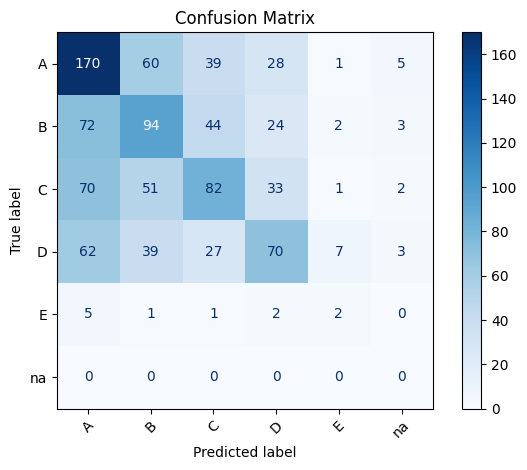

{'accuracy': 0.418,
 'precision': 0.30946646247192083,
 'recall': 0.30263573710122865}

In [ ]:
from metrics.evaluation_suite import EvaluationSuite
evaluation_suite = EvaluationSuite()

evaluation_suite.evaluate_discrete_answers(predicted_answer_multiple_choice, ground_truth, experiment_name="AdvRAG_7bcoder_MC_1000", RAG_sources=sources)


### 2. EVAL: Short Answer on 500 questions

In [ ]:
# reset sources
sources = {
    'SA3-thedevastator/comprehensive-medical-q-a-dataset': 0,
    'SA1-HPAI-BSC/OpenMedQA': 0,
    'MH-FreedomIntelligence/medical-o1-reasoning-SFT': 0,
    'MC3-openlifescienceai/medmcqa': 0,
    'SA2-Ajayaadhi/Medical-QA': 0,
    'MC4-UCSC-VLAA/MedReason': 0,
    'MC2-stellalisy/mediQ': 0,
    'TF2-qiaojin/PubMedQA': 0,
    'MC1-bigbio/med_qa': 0,
    'PubMed': 0
    }
pprint.pp(sources)

{'SA2-Ajayaadhi/Medical-QA': 0,
 'MH-FreedomIntelligence/medical-o1-reasoning-SFT': 0,
 'SA1-HPAI-BSC/OpenMedQA': 0,
 'MC2-stellalisy/mediQ': 0,
 'MC3-openlifescienceai/medmcqa': 0,
 'MC4-UCSC-VLAA/MedReason': 0,
 'SA3-thedevastator/comprehensive-medical-q-a-dataset': 0,
 'MC1-bigbio/med_qa': 0,
 'TF2-qiaojin/PubMedQA': 0,
 'PubMed': 0}


In [ ]:
sa_testset = testset['short_answer']
sa_testset = Dataset.to_list(sa_testset)[:500]

ground_truth = [entry['answer'] for entry in sa_testset[:500]]

predictions_short_answer = []


rag_pipeline = RAGAdvPipeline(
    test_data=sa_testset,
    full_data=full_data,
    pubmed_data=pubmed_data,
    pc=pc,
    question_type="sa"
)

qa_chain = rag_pipeline.chain

for i, sample in enumerate(tqdm(sa_testset)):
    question = sample["question"]
    gold_answer = sample["answer"]

    generated_answer = qa_chain.invoke({"question": question})

    result = {
        "question": question,
        "true_answer": gold_answer,
        "generated_answer": generated_answer
    }

    predictions_short_answer.append(result)

    if i % 10 == 0:
        import gc
        import torch
        gc.collect()
        torch.cuda.empty_cache()

In [ ]:
ground_truth_sa = [entry['answer'] for entry in sa_testset[:500]]

In [ ]:
from utils.RAG_answer import extract_short_answer_text

answers_sa, blocked_count = extract_short_answer_text(predictions_short_answer)

print("Blocked answers:", blocked_count)
print("First few predictions:", answers_sa[:5])


In [ ]:
evaluation_suite = EvaluationSuite()

evaluation_suite.evaluate_string_answers(answers_sa, ground_truth_sa, experiment_name="AdvRAG_7bcoder_SA_500", RAG_sources=sources)

rouge_scores [{'rouge1': 0.416, 'rouge2': 0.2926829268292683, 'rougeL': 0.336}, {'rouge1': 0.8, 'rouge2': 0.7878787878787878, 'rougeL': 0.8}, {'rouge1': 0.6666666666666667, 'rouge2': 0.4724409448818897, 'rougeL': 0.6046511627906977}, {'rouge1': 0.23529411764705885, 'rouge2': 0.07665505226480837, 'rougeL': 0.15916955017301035}, {'rouge1': 0.5296803652968036, 'rouge2': 0.38709677419354843, 'rougeL': 0.4200913242009132}, {'rouge1': 0.4293193717277487, 'rouge2': 0.09523809523809523, 'rougeL': 0.25130890052356025}, {'rouge1': 0.11764705882352941, 'rouge2': 0.024096385542168672, 'rougeL': 0.11764705882352941}, {'rouge1': 0.4719101123595506, 'rouge2': 0.45977011494252873, 'rougeL': 0.4719101123595506}, {'rouge1': 0.38461538461538464, 'rouge2': 0.11764705882352941, 'rougeL': 0.21153846153846154}, {'rouge1': 0.5573770491803279, 'rouge2': 0.26519337016574585, 'rougeL': 0.33879781420765026}, {'rouge1': 0.5656565656565656, 'rouge2': 0.3673469387755102, 'rougeL': 0.4141414141414141}, {'rouge1': 0.4

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rouge_scores:  [{'rouge1': 0.416, 'rouge2': 0.2926829268292683, 'rougeL': 0.336}, {'rouge1': 0.8, 'rouge2': 0.7878787878787878, 'rougeL': 0.8}, {'rouge1': 0.6666666666666667, 'rouge2': 0.4724409448818897, 'rougeL': 0.6046511627906977}, {'rouge1': 0.23529411764705885, 'rouge2': 0.07665505226480837, 'rougeL': 0.15916955017301035}, {'rouge1': 0.5296803652968036, 'rouge2': 0.38709677419354843, 'rougeL': 0.4200913242009132}, {'rouge1': 0.4293193717277487, 'rouge2': 0.09523809523809523, 'rougeL': 0.25130890052356025}, {'rouge1': 0.11764705882352941, 'rouge2': 0.024096385542168672, 'rougeL': 0.11764705882352941}, {'rouge1': 0.4719101123595506, 'rouge2': 0.45977011494252873, 'rougeL': 0.4719101123595506}, {'rouge1': 0.38461538461538464, 'rouge2': 0.11764705882352941, 'rougeL': 0.21153846153846154}, {'rouge1': 0.5573770491803279, 'rouge2': 0.26519337016574585, 'rougeL': 0.33879781420765026}, {'rouge1': 0.5656565656565656, 'rouge2': 0.3673469387755102, 'rougeL': 0.4141414141414141}, {'rouge1': 0

{'avg_bleu': 0.11778065094304797,
 'avg_meteor': 0.29498200734678615,
 'rouge1': 0.3389806442413773,
 'rouge2': 0.21009368650290755,
 'rougeL': 0.2689311848257376,
 'word_similarity': 0.8503310610663216,
 'sentence_similarity': 0.8007892765526502,
 'paragraph_similarity': 0.8503310610663216,
 'semantic_match_score': 0.8354685517976869,
 'precision': 0.8482890129089355,
 'recall': 0.869712769985199,
 'f1': 0.8576815724372864,
 'avg_cosine_similarity': 0.8503310610663216,
 'avg_reasoning_coherence': 0.7272013641753287}

### 3. EVAL: True False on 1000 questions

In [ ]:
# reset sources
sources = {
    'SA3-thedevastator/comprehensive-medical-q-a-dataset': 0,
    'SA1-HPAI-BSC/OpenMedQA': 0,
    'MH-FreedomIntelligence/medical-o1-reasoning-SFT': 0,
    'MC3-openlifescienceai/medmcqa': 0,
    'SA2-Ajayaadhi/Medical-QA': 0,
    'MC4-UCSC-VLAA/MedReason': 0,
    'MC2-stellalisy/mediQ': 0,
    'TF2-qiaojin/PubMedQA': 0,
    'MC1-bigbio/med_qa': 0,
    'PubMed': 0
    }
pprint.pp(sources)

{'SA3-thedevastator/comprehensive-medical-q-a-dataset': 0,
 'SA1-HPAI-BSC/OpenMedQA': 0,
 'MH-FreedomIntelligence/medical-o1-reasoning-SFT': 0,
 'MC3-openlifescienceai/medmcqa': 0,
 'SA2-Ajayaadhi/Medical-QA': 0,
 'MC4-UCSC-VLAA/MedReason': 0,
 'MC2-stellalisy/mediQ': 0,
 'TF2-qiaojin/PubMedQA': 0,
 'MC1-bigbio/med_qa': 0,
 'PubMed': 0}


In [ ]:
tf_testset = testset['true_false']
tf_testset = Dataset.to_list(tf_testset)[:1000]

ground_truth = [entry['answer'] for entry in tf_testset]

In [ ]:
ground_truth[:10]

['False',
 'False',
 'False',
 'True',
 'False',
 'False',
 'True',
 'True',
 'False',
 'False']

In [ ]:
predictions_tf = []


rag_pipeline = RAGAdvPipeline(
    test_data=tf_testset,
    full_data=full_data,
    pubmed_data=pubmed_data,
    pc=pc,
    question_type="tf"
)

qa_chain = rag_pipeline.chain

for i, sample in enumerate(tqdm(tf_testset)):
    question = sample["question"]
    gold_answer = sample["answer"]

    generated_answer = qa_chain.invoke({"question": question})

    result = {
        "question": question,
        "true_answer": gold_answer,
        "generated_answer": generated_answer
    }

    predictions_tf.append(result)

    if i % 10 == 0:
        import gc
        import torch
        gc.collect()
        torch.cuda.empty_cache()

100%|██████████| 1000/1000 [14:53<00:00,  1.12it/s]


In [ ]:
from utils.RAG_answer import extract_true_false_answers

predicted_answer_tf = extract_true_false_answers(predictions_tf)

In [ ]:
sources

{'SA3-thedevastator/comprehensive-medical-q-a-dataset': 25,
 'SA1-HPAI-BSC/OpenMedQA': 3,
 'MH-FreedomIntelligence/medical-o1-reasoning-SFT': 84,
 'MC3-openlifescienceai/medmcqa': 319,
 'SA2-Ajayaadhi/Medical-QA': 81,
 'MC4-UCSC-VLAA/MedReason': 24,
 'MC2-stellalisy/mediQ': 5,
 'TF2-qiaojin/PubMedQA': 4437,
 'MC1-bigbio/med_qa': 21,
 'PubMed': 1}

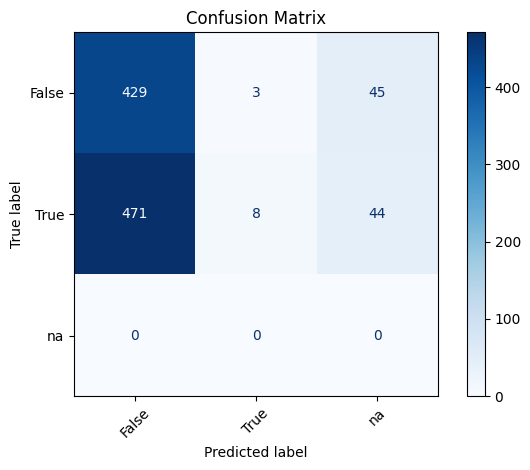

{'accuracy': 0.437,
 'precision': 0.40131313131313134,
 'recall': 0.30488914543173357}

In [ ]:
# Extract predicted and correct answers
y_pred_true_false = [entry['predicted_answer'] for entry in predicted_answer_tf]
y_true_true_false = [entry['answer'] for entry in tf_testset[:1000]]

evaluation_suite.evaluate_discrete_answers(y_pred_true_false, y_true_true_false, experiment_name="AdvRAG_7bcoder_TF_1000", RAG_sources=sources)

### 4. EVAL:  Multi Hop on 500 questions

In [ ]:

sources = {
    'SA3-thedevastator/comprehensive-medical-q-a-dataset': 0,
    'SA1-HPAI-BSC/OpenMedQA': 0,
    'MH-FreedomIntelligence/medical-o1-reasoning-SFT': 0,
    'MC3-openlifescienceai/medmcqa': 0,
    'SA2-Ajayaadhi/Medical-QA': 0,
    'MC4-UCSC-VLAA/MedReason': 0,
    'MC2-stellalisy/mediQ': 0,
    'TF2-qiaojin/PubMedQA': 0,
    'MC1-bigbio/med_qa': 0,
    'PubMed': 0
    }


pprint.pp(sources)

{'SA3-thedevastator/comprehensive-medical-q-a-dataset': 0,
 'SA1-HPAI-BSC/OpenMedQA': 0,
 'MH-FreedomIntelligence/medical-o1-reasoning-SFT': 0,
 'MC3-openlifescienceai/medmcqa': 0,
 'SA2-Ajayaadhi/Medical-QA': 0,
 'MC4-UCSC-VLAA/MedReason': 0,
 'MC2-stellalisy/mediQ': 0,
 'TF2-qiaojin/PubMedQA': 0,
 'MC1-bigbio/med_qa': 0,
 'PubMed': 0}


In [ ]:
mh_testset = testset['multi_hop']
mh_testset = Dataset.to_list(mh_testset)[:500]

In [ ]:
ground_truth_mh = [entry['answer'] for entry in mh_testset[:500]]

In [ ]:
predictions_mh = []


rag_pipeline = RAGAdvPipeline(
    test_data=mh_testset,
    full_data=full_data,
    pubmed_data=pubmed_data,
    pc=pc,
    question_type="mh"
)

qa_chain = rag_pipeline.chain

for i, sample in enumerate(tqdm(mh_testset)):
    question = sample["question"]
    gold_answer = sample["answer"]

    generated_answer = qa_chain.invoke({"question": question})

    result = {
        "question": question,
        "true_answer": gold_answer,
        "generated_answer": generated_answer
    }

    predictions_mh.append(result)

    if i % 10 == 0:
        import gc
        import torch
        gc.collect()
        torch.cuda.empty_cache()

  0%|          | 0/500 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/621 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

Device set to use cuda:0
<ipython-input-28-7446edbf2be1>:77: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  model_pipeline = HuggingFacePipeline(pipeline=pipe)
100%|██████████| 500/500 [56:37<00:00,  6.79s/it]


In [ ]:
predictions_mh[1]

[{'question': 'A 27-year-old African American man presents with episodes of severe pain, a lab finding of hemoglobin at 8 g/dL, hematocrit at 28%, a mean corpuscular volume of 72 um^3, and elevated lactate dehydrogenase (LDH) at 540 U/L. Based on these clinical and laboratory findings, what is the most likely explanation for his hemolytic anemia?',
  'true_answer': "The most likely explanation for the patient's hemolytic anemia is sickle cell disease. The episodes of severe pain are characteristic of vaso-occlusive crises commonly seen in sickle cell disease. While the mean corpuscular volume (MCV) is lower than expected for sickle cell anemia, which typically presents as normocytic or macrocytic anemia, this could be due to an additional factor such as iron deficiency, which can cause microcytic anemia. The elevated lactate dehydrogenase (LDH) supports ongoing hemolysis, and the demographic factor of being African American also aligns with sickle cell disease being a common condition 

In [ ]:
print(predictions_mh[0][0]['generated_answer'])

Context:
    A novel PET radiotracer is being evaluated for its ability to aid in the diagnosis of Alzheimer’s disease (AD). The study decides to use a sample size of 1,000 patients, and half of the patients enrolled have AD. In the group of patients with AD, 400 are found positive on the novel type of PET imaging examination. In the control group, 50 are found positive. What is the PPV of this novel exam? 
A novel PET radiotracer is being evaluated for its ability to aid in the diagnosis of Alzheimer’s disease (AD). The study decides to use a sample size of 1,000 patients, and half of the patients enrolled have AD. In the group of patients with AD, 400 are found positive on the novel type of PET imaging examination. In the control group, 50 are found positive. What is the PPV of this novel exam? 
A novel PET radiotracer is being evaluated for its ability to aid in the diagnosis of Alzheimer’s disease (AD). The study decides to use a sample size of 1,000 patients, and half of the patie

In [ ]:
from utils.RAG_answer import extract_multi_hop_answers

predicted_answer_mh, blocked_mh = extract_multi_hop_answers(predictions_mh)

print("Blocked multi-hop responses:", blocked_mh)
print("First few predictions:", predicted_answer_mh)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:


evaluation_suite = EvaluationSuite()

evaluation_suite.evaluate_string_answers(predicted_answer_mh, ground_truth_mh, experiment_name="AdvRAG_7bcoder_MH_500", RAG_sources=sources)

rouge_scores [{'rouge1': 0.6298701298701299, 'rouge2': 0.2875816993464052, 'rougeL': 0.33116883116883117}, {'rouge1': 0.5375494071146245, 'rouge2': 0.2549800796812749, 'rougeL': 0.33992094861660077}, {'rouge1': 0.5185185185185185, 'rouge2': 0.208955223880597, 'rougeL': 0.26666666666666666}, {'rouge1': 0.5130434782608696, 'rouge2': 0.23684210526315788, 'rougeL': 0.3130434782608696}, {'rouge1': 0.5589519650655023, 'rouge2': 0.44933920704845814, 'rougeL': 0.48034934497816595}, {'rouge1': 0.22340425531914895, 'rouge2': 0.03225806451612903, 'rougeL': 0.11702127659574466}, {'rouge1': 0.5579710144927537, 'rouge2': 0.1751824817518248, 'rougeL': 0.2536231884057971}, {'rouge1': 0.4881889763779527, 'rouge2': 0.21428571428571427, 'rougeL': 0.28346456692913385}, 0, {'rouge1': 0.023809523809523808, 'rouge2': 0.0, 'rougeL': 0.023809523809523808}, {'rouge1': 0.3865546218487395, 'rouge2': 0.15254237288135594, 'rougeL': 0.21848739495798322}, 0, {'rouge1': 0.019230769230769232, 'rouge2': 0.0, 'rougeL': 0

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rouge_scores:  [{'rouge1': 0.6298701298701299, 'rouge2': 0.2875816993464052, 'rougeL': 0.33116883116883117}, {'rouge1': 0.5375494071146245, 'rouge2': 0.2549800796812749, 'rougeL': 0.33992094861660077}, {'rouge1': 0.5185185185185185, 'rouge2': 0.208955223880597, 'rougeL': 0.26666666666666666}, {'rouge1': 0.5130434782608696, 'rouge2': 0.23684210526315788, 'rougeL': 0.3130434782608696}, {'rouge1': 0.5589519650655023, 'rouge2': 0.44933920704845814, 'rougeL': 0.48034934497816595}, {'rouge1': 0.22340425531914895, 'rouge2': 0.03225806451612903, 'rougeL': 0.11702127659574466}, {'rouge1': 0.5579710144927537, 'rouge2': 0.1751824817518248, 'rougeL': 0.2536231884057971}, {'rouge1': 0.4881889763779527, 'rouge2': 0.21428571428571427, 'rougeL': 0.28346456692913385}, 0, {'rouge1': 0.023809523809523808, 'rouge2': 0.0, 'rougeL': 0.023809523809523808}, {'rouge1': 0.3865546218487395, 'rouge2': 0.15254237288135594, 'rougeL': 0.21848739495798322}, 0, {'rouge1': 0.019230769230769232, 'rouge2': 0.0, 'rougeL':

{'avg_bleu': 0.15646338222927533,
 'avg_meteor': 0.358901704488933,
 'rouge1': 0.4071218832001943,
 'rouge2': 0.2453997830726597,
 'rougeL': 0.294849477477959,
 'word_similarity': 0.8554538801836847,
 'sentence_similarity': 0.798652533271522,
 'paragraph_similarity': 0.8554538801836847,
 'semantic_match_score': 0.8384135033342803,
 'precision': 0.8622000813484192,
 'recall': 0.8915843367576599,
 'f1': 0.8763863444328308,
 'avg_cosine_similarity': 0.8554538801836847,
 'avg_reasoning_coherence': 0.7097729642822712}

---

# Version 2: 100k k training data, 100k k PubMed data samples (balanced)
- training data contained **only** True questions

In [ ]:
! pip install langchain_pinecone
! pip install pinecone sentence-transformers
! pip install langchain_community
! pip install rouge_score
! pip install bert_score
! pip install datasets
! python -m spacy download en_core_web_md
! pip install spacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.11.15
    Uninstalling aiohttp-3.11.15:
      Successfully uninstalled aiohttp-3.11.15
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!git clone https://github.com/LorenaRaichle/ClinIQ.git
%cd /content/ClinIQ
from google.colab import userdata

Cloning into 'ClinIQ'...
remote: Enumerating objects: 36359, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 36359 (delta 99), reused 96 (delta 50), pack-reused 36189 (from 1)
Receiving objects: 100% (36359/36359), 176.50 MiB | 16.70 MiB/s, done.
Resolving deltas: 100% (13061/13061), done.
Updating files: 100% (143/143), done.
/content/ClinIQ


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datasets import Dataset, DatasetDict
import pprint
import json
import logging
import torch

from collections import Counter

import re
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

### check populated second index: "balanced-index"

In [ ]:
from google.colab import userdata
PINECONE = userdata.get('PINECONE')
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key=PINECONE, environment="us-west1-gcp")

index_name = "balanced-index"
indices = [index["name"] for index in pc.list_indexes()]
if index_name not in indices:
  pc.create_index(
      name=index_name,
      dimension=1024,
      metric="cosine",
      spec=ServerlessSpec(
          cloud="aws",
          region="us-east-1"
      )
)

  print(f"Index {index_name} created successfully.")
else:
  print(f"Index {index_name} already exists.")
index = pc.Index(index_name)
index.describe_index_stats()

Index balanced-index already exists.


{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 175763}},
 'total_vector_count': 175763,
 'vector_type': 'dense'}

### loading testset data, pubmed and full data for context lookup

In [ ]:
%cd /content/ClinIQ
from utils.RAG_metadata import extract_keywords_and_entities, extract_age_gender
from utils.RAG_preprocessing import DataPaths, DataStats
from utils.prompt_utils import build_prompt, generate_model_input

/content/ClinIQ


/usr/local/lib/python3.11/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_ner_bc5cdr_md' (0.5.4) was trained with spaCy v3.7.4 and may not be 100% compatible with the current version (3.8.6). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/spacy/language.py:2232: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [ ]:
# loading testset
json_file_path = '/content/drive/MyDrive/LORENA/RAG/test_dataset_balanced_shuffled.json'
with open(json_file_path, 'r') as file:
    testset = json.load(file)
testset = DatasetDict({
    split: Dataset.from_list(split_data)
    for split, split_data in testset.items()
})
print(testset.keys())
testset = testset.map(generate_model_input)

pprint.pp(testset['multiple_choice'][0])

dict_keys(['true_false', 'multiple_choice', 'short_answer', 'multi_hop'])


Map:   0%|          | 0/5971 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/54060 [00:00<?, ? examples/s]

Map:   0%|          | 0/15763 [00:00<?, ? examples/s]

{'options': {'A': 'Persistent corpus luteum',
             'B': 'Deficient corpus luteum',
             'C': 'Persistent trophoblast',
             'D': 'Deficient trophoblast',
             'E': None},
 'question': "Halban's disease is due to",
 'source': 'MC3-openlifescienceai/medmcqa',
 'type': 'multiple_choice',
 'prompt': '\n'
           '        "Halban\'s disease is due to\n'
           'Options:\n'
           'A. Persistent corpus luteum\n'
           'B. Deficient corpus luteum\n'
           'C. Persistent trophoblast\n'
           'D. Deficient trophoblast\n'
           'E. None\n'
           '"\n'
           '\n'
           '        ### What is the correct answer? Please state only the '
           'letter:\n'
           '        ',
 'answer': 'A',
 'prompt_n_answer': '\n'
                    '        "Halban\'s disease is due to\n'
                    'Options:\n'
                    'A. Persistent corpus luteum\n'
                    'B. Deficient corpus luteum\n'
        

In [ ]:
# # Load PubMed context data (to look up for retrieved id the context)
#pubmed_data = DataPaths.load("pubmed_preprocessed_250k")
#pubmed_data[0]

file_path = "/content/drive/MyDrive/LORENA/RAG/pubmed_sample_prepro.jsonl"

pubmed_data = []
with open(file_path, "r") as f:
    for line in f:
        pubmed_data.append(json.loads(line))
print(pubmed_data[:1])

[{'id': 'pubmed_466957', 'title': '[Retention of 241Am in the rat and the Syrian hamster].', 'content': 'The retention of 241-Am during the first three months after injection as well as its microdistribution on the 2nd day were investigated in the rat and the Syrian hamster. Deposition, retention and microdistribution in the skeleton of both species are virtually identical; the same holds for kidneys, except for a higher initial deposition in the hamster. The microdistribution of 241-Am in kidneys and liver of both species is homogenous with a distinct accumulation in the cortical zone of the kidneys. A pronounced difference was observed with regard to the elimination of 241-Am from the liver: Most of the 241-Am is excreted by the rat liver with a half time of 7 days whereas this value is about 150 days for the Syrian hamster. The consequences of the species differences are discussed.', 'contents': '[Retention of 241Am in the rat and the Syrian hamster]. The retention of 241-Am during 

In [ ]:
#oad full training data (to look up for retrieved id the context)
train_data = DataPaths.load("train_processed")
full_data = DatasetDict({
   split: Dataset.from_list(data) for split, data in train_data.items()
})

full_data["multiple_choice"][0]


{'correct_answer': '2-3 year after eruption', 'options': {'A': '1-1 ½ year after eruption', 'B': '2-3 year after eruption', 'C': '6 months after eruption', 'D': 'None of the above', 'E': None}, 'question': 'Root completion of permanent tooth occurs', 'source': 'MC3-openlifescienceai/medmcqa', 'type': 'multiple_choice', 'id': 'mc_0'}


### spacy to extract metadata from user query

In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/LORENA/RAG/en_ner_bc5cdr_md-0.5.4-20250531T160242Z-1-001.zip"
extract_path = "/content/drive/MyDrive/LORENA/RAG/en_ner_bc5cdr_md"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

import spacy

nlp = spacy.load("/content/drive/MyDrive/LORENA/RAG/en_ner_bc5cdr_md/en_ner_bc5cdr_md-0.5.4")

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings

embedder = HuggingFaceEmbeddings(model_name="BAAI/bge-large-en-v1.5")


<ipython-input-11-627eccd039b4>:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedder = HuggingFaceEmbeddings(model_name="BAAI/bge-large-en-v1.5")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warning

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

### loading fine tuned deepseek

In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/LORENA/RAG/ft_multiple_choice_v2_balanced_and_shuffled-20250531T154625Z-1-001.zip"
extract_path = "/content/drive/MyDrive/LORENA/RAG/DS"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
sources = {
    'SA3-thedevastator/comprehensive-medical-q-a-dataset': 0,
    'SA1-HPAI-BSC/OpenMedQA': 0,
    'MH-FreedomIntelligence/medical-o1-reasoning-SFT': 0,
    'MC3-openlifescienceai/medmcqa': 0,
    'SA2-Ajayaadhi/Medical-QA': 0,
    'MC4-UCSC-VLAA/MedReason': 0,
    'MC2-stellalisy/mediQ': 0,
    'TF2-qiaojin/PubMedQA': 0,
    'MC1-bigbio/med_qa': 0,
    'PubMed': 0
    }
pprint.pp(sources)

{'SA3-thedevastator/comprehensive-medical-q-a-dataset': 0,
 'SA1-HPAI-BSC/OpenMedQA': 0,
 'MH-FreedomIntelligence/medical-o1-reasoning-SFT': 0,
 'MC3-openlifescienceai/medmcqa': 0,
 'SA2-Ajayaadhi/Medical-QA': 0,
 'MC4-UCSC-VLAA/MedReason': 0,
 'MC2-stellalisy/mediQ': 0,
 'TF2-qiaojin/PubMedQA': 0,
 'MC1-bigbio/med_qa': 0,
 'PubMed': 0}


### Version 2 : 1.Eval MC on 1000 questions

In [ ]:
!git pull


Already up to date.


In [ ]:
import importlib
import utils.RAG_adv_pipeline
importlib.reload(utils.RAG_adv_pipeline)


<module 'utils.RAG_adv_pipeline' from '/content/ClinIQ/utils/RAG_adv_pipeline.py'>

In [ ]:
import os

model_path = "/content/drive/MyDrive/LORENA/RAG/DS/ft_multiple_choice_v2_balanced_and_shuffled"
print("Exists:", os.path.isdir(model_path))
print("Files:", os.listdir(model_path))


Exists: True
Files: ['special_tokens_map.json', 'README.md', 'tokenizer_config.json', 'adapter_config.json', 'tokenizer.json', 'adapter_model.safetensors']


In [ ]:
! pip install peft

In [ ]:
from tqdm import tqdm
from utils.RAG_adv_pipeline import RAGAdvPipeline
torch.cuda.empty_cache()
mc_testset = testset['multiple_choice']
mc_testset = Dataset.to_list(mc_testset)[:15]

ground_truth = [entry['answer'] for entry in mc_testset]
predictions_multiple_choice = []
torch.cuda.empty_cache()


rag_pipeline = RAGAdvPipeline(
    test_data=mc_testset,
    full_data=full_data,
    pubmed_data=pubmed_data,
    pc=pc,
    question_type="mc"
)
qa_chain = rag_pipeline.chain

for i, sample in enumerate(tqdm(mc_testset)):
    question = sample["question"]
    gold_answer = sample["answer"]

    generated_answer = qa_chain.invoke({"question": question})

    result = {
        "question": question,
        "true_answer": gold_answer,
        "generated_answer": generated_answer
    }

    predictions_multiple_choice.append(result)

    if i % 10 == 0:
        import gc
        import torch
        gc.collect()
        torch.cuda.empty_cache()


tokenizer_config.json:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/621 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

Device set to use cuda:0
/content/ClinIQ/utils/RAG_adv_pipeline.py:173: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  self.model_pipeline = HuggingFacePipeline(pipeline=pipe)
100%|██████████| 15/15 [06:32<00:00, 26.19s/it]


In [ ]:

output_path = "/content/drive/MyDrive/LORENA/RAG/predictions_multiple_choice.json"
with open(output_path, "w") as f:
    json.dump(predictions_multiple_choice, f, indent=2)

print(f"Predictions saved to {output_path}")


Predictions saved to /content/drive/MyDrive/LORENA/RAG/predictions_multiple_choice.json


In [ ]:
for i, result in enumerate(predictions_multiple_choice[:5]):
    print(f"\nExample {i+1}:")
    print(result['generated_answer'])



Example 1:
Context:
        Farber’s disease is caused due to 
Pancreatitis caused bya) Ascending cholangitisb) ↑ed PTHc) CBD stoned) Alcohole) Starvation 
What causes Brody myopathy ? What causes Brody disease? Brody disease can be caused by mutations in the gene ATP2A1. In general, genes contain the information needed to make functional molecules called proteins. These proteins are required for our bodies cells (and ultimately tissues, like our muscles) to work correctly. Gene mutations can result in faulty proteins. The ATP2A1 gene tells the body how to make a protein called SERCA Ca(2+)-ATPase. This protein is involved in moving calcium around in the cell, which is important for normal muscle contraction. Mutations in this gene results in problems with calcium transportation in the cell, and ultimately problems with muscle contraction. Not all people with Brody disease have mutations in the ATP2A1 gene. There are likely other gene mutations, that have not yet been identified, that

In [ ]:
mc_testset[0]


{'options': {'A': 'Persistent corpus luteum',
  'B': 'Deficient corpus luteum',
  'C': 'Persistent trophoblast',
  'D': 'Deficient trophoblast',
  'E': None},
 'question': "Halban's disease is due to",
 'source': 'MC3-openlifescienceai/medmcqa',
 'type': 'multiple_choice',
 'prompt': '\n        "Halban\'s disease is due to\nOptions:\nA. Persistent corpus luteum\nB. Deficient corpus luteum\nC. Persistent trophoblast\nD. Deficient trophoblast\nE. None\n"\n\n        ### What is the correct answer? Please state only the letter:\n        ',
 'answer': 'A',
 'prompt_n_answer': '\n        "Halban\'s disease is due to\nOptions:\nA. Persistent corpus luteum\nB. Deficient corpus luteum\nC. Persistent trophoblast\nD. Deficient trophoblast\nE. None\n"\n\n        ### What is the correct answer? Please state only the letter:\n        A'}

In [ ]:
from utils.RAG_answer import extract_multiple_choice_letters
# extract characters out of given answer
predicted_answer_multiple_choice = extract_multiple_choice_letters(predictions_multiple_choice)

In [ ]:
from metrics.evaluation_suite import EvaluationSuite
evaluation_suite = EvaluationSuite()

evaluation_suite.evaluate_discrete_answers(predicted_answer_multiple_choice, ground_truth, experiment_name="Balanced-AdvRAG_7bcoder_MC_1000", RAG_sources=sources)

In [ ]:
from metrics.evaluation_suite import EvaluationSuite
evaluation_suite = EvaluationSuite()

evaluation_suite.evaluate_discrete_answers(predicted_answer_multiple_choice, ground_truth, experiment_name="BALANCED-AdvRAG_7bcoder_MC_1000", RAG_sources=sources)

### Version 2 : 2.Eval Short Answer on 500 questions

In [ ]:
# reset sources
sources = {
    'SA3-thedevastator/comprehensive-medical-q-a-dataset': 0,
    'SA1-HPAI-BSC/OpenMedQA': 0,
    'MH-FreedomIntelligence/medical-o1-reasoning-SFT': 0,
    'MC3-openlifescienceai/medmcqa': 0,
    'SA2-Ajayaadhi/Medical-QA': 0,
    'MC4-UCSC-VLAA/MedReason': 0,
    'MC2-stellalisy/mediQ': 0,
    'TF2-qiaojin/PubMedQA': 0,
    'MC1-bigbio/med_qa': 0,
    'PubMed': 0
    }
pprint.pp(sources)

In [ ]:
sa_testset = testset['short_answer']
sa_testset = Dataset.to_list(sa_testset)[:500]

ground_truth = [entry['answer'] for entry in sa_testset[:500]]

predictions_short_answer = []


rag_pipeline = RAGAdvPipeline(
    test_data=sa_testset,
    full_data=full_data,
    pubmed_data=pubmed_data,
    pc=pc,
    question_type="sa"
)

qa_chain = rag_pipeline.chain

for i, sample in enumerate(tqdm(sa_testset)):
    question = sample["question"]
    gold_answer = sample["answer"]

    generated_answer = qa_chain.invoke({"question": question})

    result = {
        "question": question,
        "true_answer": gold_answer,
        "generated_answer": generated_answer
    }

    predictions_short_answer.append(result)

    if i % 10 == 0:
        import gc
        import torch
        gc.collect()
        torch.cuda.empty_cache()

In [ ]:
from utils.RAG_answer import extract_short_answer_text

answers_sa, blocked_count = extract_short_answer_text(predictions_short_answer)

print("Blocked answers:", blocked_count)
print("First few predictions:", answers_sa[:5])


In [ ]:
evaluation_suite = EvaluationSuite()

evaluation_suite.evaluate_string_answers(answers_sa, ground_truth_sa, experiment_name="Balanced-AdvRAG_7bcoder_SA_500", RAG_sources=sources)

### Version 2: 3. EVAL: True False on 1000 questions

In [ ]:
# reset sources
sources = {
    'SA3-thedevastator/comprehensive-medical-q-a-dataset': 0,
    'SA1-HPAI-BSC/OpenMedQA': 0,
    'MH-FreedomIntelligence/medical-o1-reasoning-SFT': 0,
    'MC3-openlifescienceai/medmcqa': 0,
    'SA2-Ajayaadhi/Medical-QA': 0,
    'MC4-UCSC-VLAA/MedReason': 0,
    'MC2-stellalisy/mediQ': 0,
    'TF2-qiaojin/PubMedQA': 0,
    'MC1-bigbio/med_qa': 0,
    'PubMed': 0
    }
pprint.pp(sources)

In [ ]:
tf_testset = testset['true_false']
tf_testset = Dataset.to_list(tf_testset)[:1000]

ground_truth = [entry['answer'] for entry in tf_testset]
ground_truth[:10]

In [ ]:
predictions_tf = []


rag_pipeline = RAGAdvPipeline(
    test_data=tf_testset,
    full_data=full_data,
    pubmed_data=pubmed_data,
    pc=pc,
    question_type="tf"
)

qa_chain = rag_pipeline.chain

for i, sample in enumerate(tqdm(tf_testset)):
    question = sample["question"]
    gold_answer = sample["answer"]

    generated_answer = qa_chain.invoke({"question": question})

    result = {
        "question": question,
        "true_answer": gold_answer,
        "generated_answer": generated_answer
    }

    predictions_tf.append(result)

    if i % 10 == 0:
        import gc
        import torch
        gc.collect()
        torch.cuda.empty_cache()

In [ ]:
from utils.RAG_answer import extract_true_false_answers

predicted_answer_tf = extract_true_false_answers(predictions_tf)

In [ ]:
sources

In [ ]:
# Extract predicted and correct answers
y_pred_true_false = [entry['predicted_answer'] for entry in predicted_answer_tf]
y_true_true_false = [entry['answer'] for entry in tf_testset[:1000]]

evaluation_suite.evaluate_discrete_answers(y_pred_true_false, y_true_true_false, experiment_name="Balanced-AdvRAG_7bcoder_TF_1000", RAG_sources=sources)

### Version 2: 4. EVAL:  Multi Hop on 500 questions

In [ ]:

sources = {
    'SA3-thedevastator/comprehensive-medical-q-a-dataset': 0,
    'SA1-HPAI-BSC/OpenMedQA': 0,
    'MH-FreedomIntelligence/medical-o1-reasoning-SFT': 0,
    'MC3-openlifescienceai/medmcqa': 0,
    'SA2-Ajayaadhi/Medical-QA': 0,
    'MC4-UCSC-VLAA/MedReason': 0,
    'MC2-stellalisy/mediQ': 0,
    'TF2-qiaojin/PubMedQA': 0,
    'MC1-bigbio/med_qa': 0,
    'PubMed': 0
    }


pprint.pp(sources)

In [ ]:
mh_testset = testset['multi_hop']
mh_testset = Dataset.to_list(mh_testset)[:500]
ground_truth_mh = [entry['answer'] for entry in mh_testset[:500]]

In [ ]:
predictions_mh = []


rag_pipeline = RAGAdvPipeline(
    test_data=mh_testset,
    full_data=full_data,
    pubmed_data=pubmed_data,
    pc=pc,
    question_type="mh"
)

qa_chain = rag_pipeline.chain

for i, sample in enumerate(tqdm(mh_testset)):
    question = sample["question"]
    gold_answer = sample["answer"]

    generated_answer = qa_chain.invoke({"question": question})

    result = {
        "question": question,
        "true_answer": gold_answer,
        "generated_answer": generated_answer
    }

    predictions_mh.append(result)

    if i % 10 == 0:
        import gc
        import torch
        gc.collect()
        torch.cuda.empty_cache()

In [ ]:
predictions_mh[1]

In [ ]:
print(predictions_mh[0][0]['generated_answer'])

In [ ]:
from utils.RAG_answer import extract_multi_hop_answers

predicted_answer_mh, blocked_mh = extract_multi_hop_answers(predictions_mh)

print("Blocked multi-hop responses:", blocked_mh)
print("First few predictions:", predicted_answer_mh)

In [ ]:
evaluation_suite = EvaluationSuite()

evaluation_suite.evaluate_string_answers(predicted_answer_mh, ground_truth_mh, experiment_name="AdvRAG_7bcoder_MH_500", RAG_sources=sources)